In [57]:
# Imports
%matplotlib inline
import os
import cv2
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import torch

# Models
from MiDaSModel import get_midas, midas_predict
from capture_utils import loadmat_h5py, z_to_r, r_to_z, rescale_bins, normals_from_depth, fc_kinect, fc_spad, \
                          get_closer_to_mod, load_spad, preprocess_spad, load_and_crop_kinect, get_hist_med, \
                          depth_imwrite, savefig_no_whitespace
from models.data.data_utils.sid_utils import SID
from models.loss import get_depth_metrics
from remove_dc_from_spad import remove_dc_from_spad_edge
from weighted_histogram_matching import image_histogram_match, image_histogram_match_variable_bin
# from spad_utils import rescale_bins

from camera_utils import extract_camera_params, project_depth, undistort_img

from models.core.checkpoint import safe_makedir

import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl

In [58]:
def crop_and_scale_figure(img, crop, newmin, newmax):
    """
    Assumes img is in [0,1]
    """
    img = img * (newmax - newmin) + newmin
    return img[crop[0]:crop[1], crop[2]:crop[3], ...]

def get_diff_maps_and_rmses(gt, preds, mask):
    """
    Compares gt map to all preds and outputs a diff map for each one,
    as well as a range of diffs for the colorbar (min is always 0)
    """
    diffs = []
    rmses = []
    for pred in preds:
        diffs.append(np.abs(gt - pred)*mask)
        rmses.append(np.sqrt(np.mean((gt - pred)**2*mask)))
    max_diff = max(np.max(diff) for diff in diffs)
    return diffs, rmses, max_diff


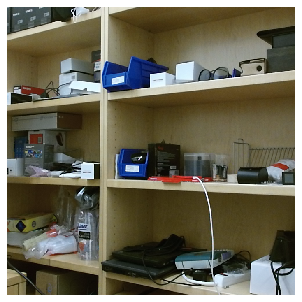

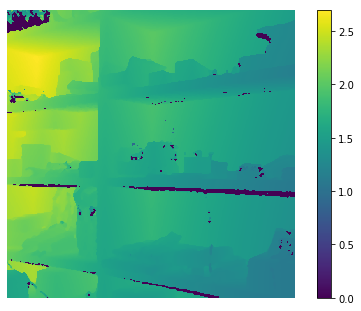

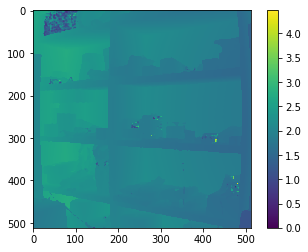

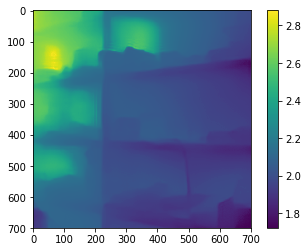

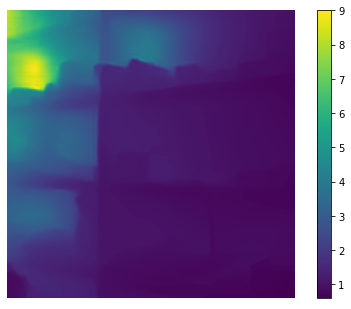

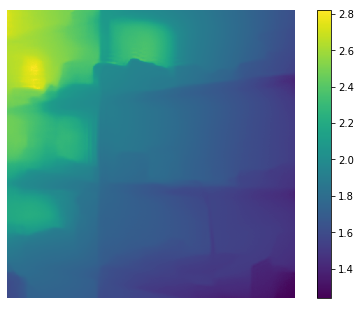

In [86]:
# Load Images
figure_dir = "figures"
# scene = "8_30_conference_room2_scene"
# scene = "8_31_outdoor3"
scene = "8_30_small_lab_scene"


model = "midas"
# square crop everything with side length s
s = 700
scenedir = os.path.join(figure_dir, model, scene)

# Get the Ground truth sorted out
a = np.load(os.path.join(scenedir, "mins_and_maxes.npy"), allow_pickle=True).item()
gt_z_proj_crop = plt.imread(os.path.join(scenedir, "gt_z_proj_crop.png"))
gt_r = cv2.imread(os.path.join(scenedir, "gt_r.png"), cv2.IMREAD_UNCHANGED)
top = gt_z_proj_crop.shape[0]//2 - s//2
bot = gt_z_proj_crop.shape[0]//2 + s//2
left = gt_z_proj_crop.shape[1]//2 - s//2
right = gt_z_proj_crop.shape[1]//2 + s//2
figure_crop = (top, bot, left, right)
gt_z_proj_crop = crop_and_scale_figure(gt_z_proj_crop, figure_crop, a["gt_z_proj_crop"][0], a["gt_z_proj_crop"][1])
gt_r = gt_r * (a["gt_r"][1] - a["gt_r"][0])/65535. + a["gt_r"][0] # Scale to be in the proper range

z_init = crop_and_scale_figure(plt.imread(os.path.join(scenedir, "z_init.png")), figure_crop, a["z_init"][0], a["z_init"][1])
z_pred = crop_and_scale_figure(plt.imread(os.path.join(scenedir, "z_pred.png")), figure_crop, a["z_pred"][0], a["z_pred"][1])
z_med_scaled = crop_and_scale_figure(plt.imread(os.path.join(scenedir, "z_med_scaled.png")), figure_crop,
                                     a["z_med_scaled"][0], a["z_med_scaled"][1])
r_pred = crop_and_scale_figure(cv2.imread(os.path.join(scenedir, "r_pred.png"), cv2.IMREAD_UNCHANGED)/65535.,
                               figure_crop, a["r_pred"][0], a["r_pred"][1])

mask = crop_and_scale_figure(plt.imread(os.path.join(scenedir, "mask_proj_crop.png")), figure_crop, 0., 1.)
preds = [z_init, z_med_scaled, z_pred]
names = ["z_init", "z_med_scaled", "z_pred"]
diffs, rmses, max_diff = get_diff_maps_and_rmses(gt_z_proj_crop, preds, mask)
diff_cmap = mpl.cm.Reds
diff_norm = mpl.colors.Normalize(vmin=0., vmax=max_diff)

# Also square crop the rgb image
rgb_crop = crop_and_scale_figure(plt.imread(os.path.join(scenedir, "rgb_cropped.png")), figure_crop, 0., 1.)
plt.figure()
plt.imshow(rgb_crop)
savefig_no_whitespace(os.path.join(scenedir, "rgb_cropped_teaser.png"))


plt.figure()
plt.imshow(gt_z_proj_crop)
plt.colorbar()
savefig_no_whitespace(os.path.join(scenedir, "gt_z_proj_crop_teaser.png"))

plt.figure()
plt.imshow(gt_r)
plt.colorbar()
plt.figure()
plt.imshow(r_pred)
plt.colorbar()

# plt.figure()
# plt.imshow(mask)
plt.figure()
plt.imshow(z_init)
plt.colorbar()
savefig_no_whitespace(os.path.join(scenedir, "z_init_teaser.png"))


plt.figure()
plt.imshow(z_pred)
plt.colorbar()
savefig_no_whitespace(os.path.join(scenedir, "z_pred_teaser.png"))




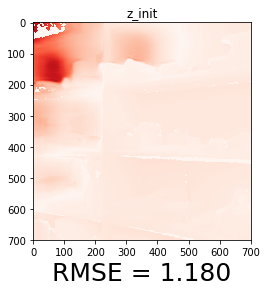

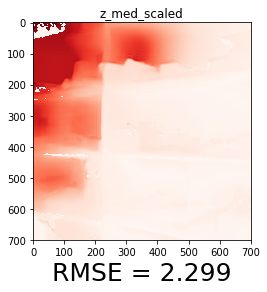

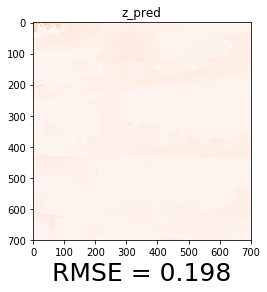

In [82]:
# Diff Maps and RMSES
for i, name in enumerate(names):
    plt.figure()
    plt.imshow(diffs[i], cmap=diff_cmap, norm=diff_norm)
    plt.xlabel("RMSE = {:0.3f}".format(rmses[i]), fontsize=25)
    plt.title(name)


In [71]:
# Load and inspect SPAD data
spad_processed = np.load(os.path.join(scenedir, "spad_processed.npy"), allow_pickle=True).item()
spad_relevant = spad_processed["spad_relevant"]
spad_sid = spad_processed["spad_sid"]

Text(0.5, 1.0, 'gt_r_hist')

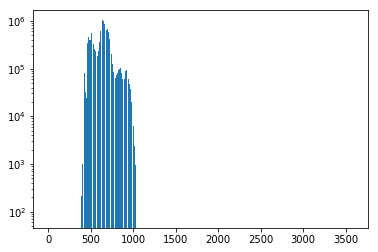

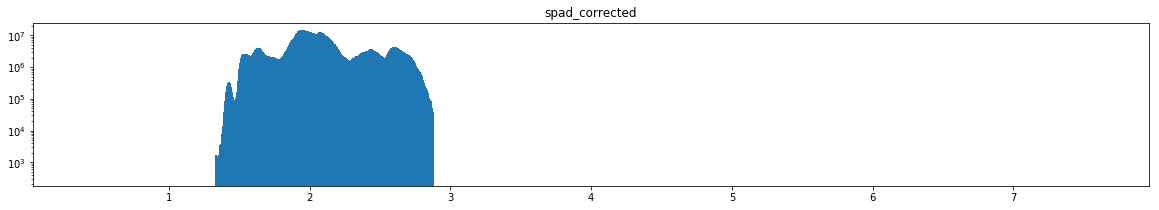

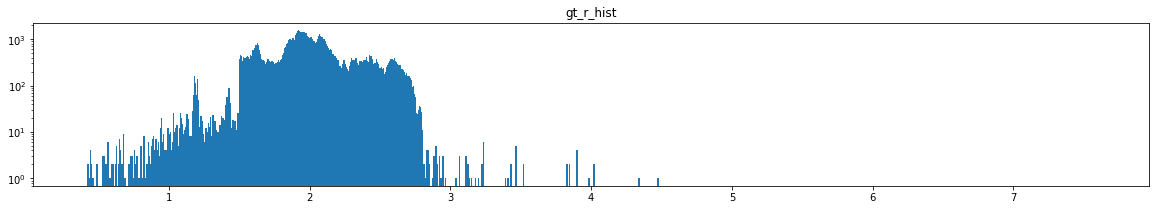

In [73]:
# plt.bar(range(len(spad_sid)), spad_sid, log=True)
min_depth = 0.4
max_depth = 9.
spad_single_relevant = np.sum(spad_relevant, axis=(0,1))
ambient_estimate = np.mean(spad_single_relevant[:100])
# plt.figure()
# plt.bar(range(len(spad_single_relevant)), spad_single_relevant, log=True)
# plt.axhline(y=ambient_estimate, color='r', linewidth=0.5)
spad_denoised = remove_dc_from_spad_edge(spad_single_relevant, ambient_estimate)
plt.figure()
plt.bar(range(len(spad_denoised)), spad_denoised, log=True)

bin_edges = np.linspace(min_depth, max_depth, len(spad_denoised) + 1)
bin_values = (bin_edges[1:] + bin_edges[:-1]) / 2
# spad_corrected = spad_denoised * bin_values ** 2
spad_corrected = spad_denoised * bin_values ** 4
min_bin = 0
max_bin = 3000
plt.figure(figsize=(20,3))
plt.bar(bin_values[min_bin:max_bin], spad_corrected[min_bin:max_bin], width=0.01, log=True)
plt.title("spad_corrected")

# Go from ground truth to SPAD
gt_r_hist, _ = np.histogram(gt_r, bins=np.linspace(min_depth, max_depth, len(spad_denoised)+1))
plt.figure(figsize=(20, 3))
plt.bar(bin_values[min_bin:max_bin], gt_r_hist[min_bin:max_bin], width = 0.01, log=True)
np.linspace(min_depth, max_depth, 100)plt.title("gt_r_hist")

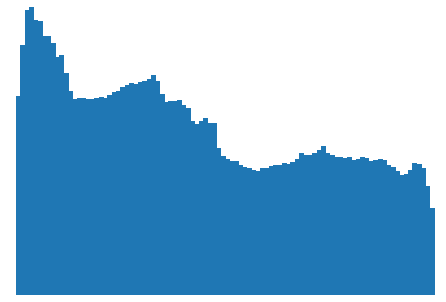

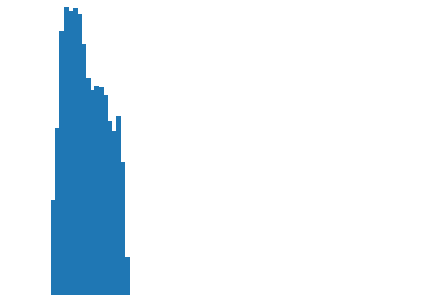

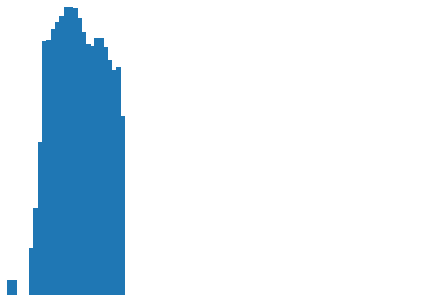

In [97]:
# Histograms
figure_min_depth = 0.4
figure_max_depth = 9.
bin_edges = np.linspace(figure_min_depth, figure_max_depth, 100)
bin_values = (bin_edges[1:] + bin_edges[:-1])/2
z_init_hist, _ = np.histogram(z_init, bins=bin_edges)
plt.figure()
plt.bar(bin_values, z_init_hist, log=True, width=0.1)
savefig_no_whitespace(os.path.join(scenedir, "z_init_hist_teaser.png"))

z_pred_hist, _ = np.histogram(z_pred, bins=bin_edges)
plt.figure()
plt.bar(bin_values, z_pred_hist, log=True, width=0.1)
savefig_no_whitespace(os.path.join(scenedir, "z_pred_hist_teaser.png"))

gt_z_hist, _ = np.histogram(gt_z_proj_crop, bins=bin_edges)
plt.figure()
plt.bar(bin_values, gt_z_hist, log=True, width=0.1)
savefig_no_whitespace(os.path.join(scenedir, "gt_z_hist_teaser.png"))
